# Weather and Commodities

The goal of this study is to examine the effect of weather on agricultural commodity prices. The initial target is to see how what percentage of price variability is explained by weather, and the secondary target is to predict commodities price movement (directional/classification or actual price). There will be two main datasets used. First is historical price data for corn, cotton, and wheat. This data is a daily closing price for every business day dating back to the 60s. Second is weather data from the National Oceanic and Atmospheric Administration(NOAA). The data set is the global summary of the day (GSOD). This provides data on a number of daily metrics such as temperature, humidity, and wind, for numerous locations across the globe. For this data set, I will only use data from the US, and given the time, only for crop growing regions. Corn, cotton, and wheat are three of the US' biggest crops. This analysis will assume that the US market is the driver of US commodity prices, while it is possible and even probable that imports from other countries would affect prices too.

### Imports

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

% matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Commodities Data

In [2]:
corn = pd.read_csv('./data/corn-price-data.csv', names=['date', 'price'], header=0)
cotton = pd.read_csv('./data/cotton-price-data.csv', names=['date', 'price'], header=0)
wheat = pd.read_csv('./data/wheat-price-data.csv', names=['date', 'price'], header=0)

In [3]:
corn['date'] = pd.to_datetime(corn.date)
cotton['date'] = pd.to_datetime(cotton.date)
wheat['date'] = pd.to_datetime(wheat.date)

In [59]:
print(corn.shape)
print(cotton.shape)
print(wheat.shape)

(12309, 2)
(12310, 2)
(10834, 2)


In [4]:
def recession(x):
    if x > pd.datetime(1975,1,1) and x < pd.datetime(1975,3,31):
        return 1
    if x > pd.datetime(1979,3,31) and x < pd.datetime(1980,6,30):
        return 1
    if x > pd.datetime(1981,3,31) and x < pd.datetime(1982,6,30):
        return 1
    if x > pd.datetime(1989,9,30) and x < pd.datetime(1991,3,31):
        return 1
    if x > pd.datetime(2001,1,1) and x < pd.datetime(2001,9,30):
        return 1
    if x > pd.datetime(2007,9,30) and x < pd.datetime(2009,6,3):
        return 1
    else:
        return 0 

In [5]:
corn['recession'] = corn.date.map(lambda x: recession(x))
cotton['recession'] = cotton.date.map(lambda x: recession(x))
wheat['recession'] = wheat.date.map(lambda x: recession(x))

In [61]:
corn.describe()

,price
count,12309.000000
mean,2.871731
std,1.283200
min,1.025000
25%,2.085000
50%,2.580000
75%,3.395000
max,8.490000


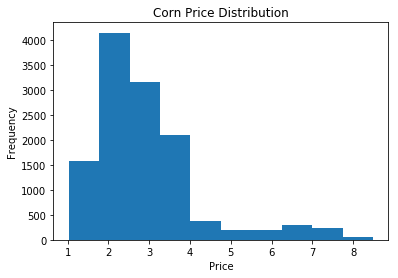

In [9]:
plt.hist(corn['price'])
plt.title('Corn Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

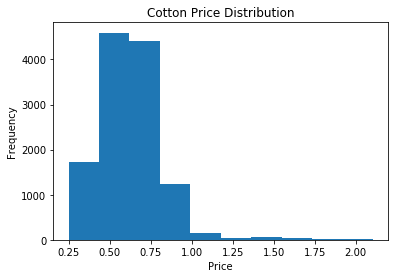

In [10]:
plt.hist(cotton['price'])
plt.title('Cotton Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

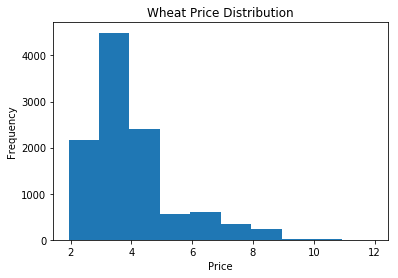

In [11]:
plt.hist(wheat['price'])
plt.title('Wheat Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency');

### Weather Data

In [2]:
# turn weather dates into date-time values
def make_date(x):
    x = str(x)
    y = x[:4] + '/' + x[4:6] + '/' + x[6:]
    return pd.to_datetime(y, yearfirst=True)

In [226]:
# station schema, to read in fixed width file
station_schema = pd.read_csv('./data/station_schema.csv')
station_specs = tuple(zip(station_schema.start, station_schema.end))

# read in fixed width station file with schema data
stations = pd.read_fwf('./data/station_ref.txt', colspecs=station_specs)

# filter stations to those in US
us_stations = stations[stations.CT == 'US']
usa_stations = [i for i in us_stations.USAF]

In [3]:
# weather data schema, to read in fixed width file
weather_schema = pd.read_csv('~/desktop/gsod_data/noaa-gsod-data-munging/gsod_schema.csv')

# column names for df
weather_schema.drop([3,4], inplace=True)
weather_schema.loc[2, 'column'] = 'DATE'
weather_schema.loc[0, 'column'] = 'STN'
weather_cols = [i for i in weather_schema.column]

# column widths for df
weather_schema['end'] = weather_schema.start + weather_schema.length
weather_schema.loc[2, 'end'] = 22
weather_specs = tuple(zip(weather_schema.start, weather_schema.end))

In [15]:
def df_specs(years, usa_stations, weather_specs, weather_cols):
    output = {}
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('~/desktop/gsod_data/data/'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)
        
        # filter weather data to US stations
        us_weather = df[df.STN.isin(usa_stations)]
        output.update({x:len(us_weather.STN.unique())})
    
    return output

In [3]:
# how many US stations per year
years = [x for x in range(1968, 2019)]
x = df_specs(years, usa_stations, weather_specs, weather_cols)

new_df = pd.DataFrame()
new_df['year'] = x.keys()
new_df['stations'] = x.values()
new_df.to_csv('~/desktop/yearly_stations.csv') # saving for reference
new_df

,year,stations
0,1968,222
1,1969,217
2,1970,205
3,1971,127
4,1972,104
5,1973,985
6,1974,983
7,1975,1077
8,1976,1118
9,1977,1157


In [68]:
# filter to US stations and clean data
def save_us_data(years, usa_stations, weather_specs, weather_cols):
    for x in years:
        # read in fixed width weather file with schema specs
        df = pd.read_fwf('~/desktop/gsod_data/data/'+str(x)+'.op', colspecs=weather_specs, header=None, names=weather_cols)

        # drop count and flag columns
        df.drop(['WBAN', 'Count (TEMP)', 'Count (DEWP)', 'Count (SLP)','Count (STP)',
                'Count (VISIB)','Count (WDSP)', 'Flag (MAX)', 'Flag (MIN)',  'Flag (PRCP)'],
                axis=1, inplace=True)
                
        # filter weather data to US stations
        df = df[df.STN.isin(usa_stations)]

        # convert to datetime object
        df.DATE = df.DATE.map(lambda x: make_date(x))

        # replace "9" values with nans in appropriate columns
        nine_thou = ['TEMP', 'DEWP', 'SLP', 'STP', 'MAX', 'MIN']
        nine_hun = ['VISIB', 'WDSP', 'MXSPD', 'GUST', 'SNDP']
        for i in nine_thou:
            df[i].replace(9999.9, np.nan, inplace=True)
        for i in nine_hun:
            df[i].replace(999.9, np.nan, inplace=True)
            df.PRCP.replace(99.99, np.nan, inplace=True)
            
        df.to_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv', index=False)

In [99]:
years = [x for x in range(1975, 2019)]
save_us_data(years, usa_stations, weather_specs, weather_cols)

In [11]:
# list of US stations in each year
stations_list = []
for x in range(1976, 2019):
    df = pd.read_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv')
    stations = [i for i in df.STN.unique()]
    stations_list.append(stations)

# US stations in the year 1975
df = pd.read_csv('~/desktop/gsod_data/data/us_data/1975.csv')
stations_75 = [i for i in df.STN.unique()]

# US stations that are in all years
common_stations = []
for each in stations_75:
    if sum(x.count(each) for x in stations_list) == len(stations_list):
        common_stations.append(each)

In [106]:
# filter to common US stations and impute missing data
def clean_same_stations(years, common_stations):
    for x in years:
        df = pd.read_csv('~/desktop/gsod_data/data/us_data/'+str(x)+'.csv')
        # filter to US stations
        df = df[df.STN.isin(common_stations)]
        
        # reset index
        df.reset_index(inplace=True)
        
        # drop bad variables
        df = df.drop(['STP', 'MXSPD', 'GUST', 'SNDP'], axis=1)

        # separate discrete variables
        disc_vars = df[['PRCP', 'Fog', 'Rain/Drizzle', 'Snow/Ice pellets', 'Hail', 'Thunder','Tornado/Funnel cloud']]

        # interpolate continuous variables
        df = df[['STN', 'DATE','TEMP', 'DEWP', 'SLP', 'VISIB', 'WDSP', 'MAX', 'MIN']]
        df.interpolate(inplace=True)

        # rejoin data
        df = df.join(disc_vars)

        # Mice impute discrete variables
        dates = df['DATE']
        df.drop('DATE', axis=1, inplace = True)
        mice = MICE(verbose=False)
        df = pd.DataFrame(mice.complete(df), columns=[df.columns])
        df = df.join(dates)
        
        df.to_csv('~/desktop/gsod_data/data/us_common_data/'+str(x)+'.csv', index=False)

In [107]:
years = [x for x in range(1975, 2019)]
clean_same_stations(years, common_stations)

In [126]:
df.isnull().sum() / len(df)

STN                     0.0
TEMP                    0.0
DEWP                    0.0
SLP                     0.0
VISIB                   0.0
WDSP                    0.0
MAX                     0.0
MIN                     0.0
PRCP                    0.0
Fog                     0.0
Rain/Drizzle            0.0
Snow/Ice pellets        0.0
Hail                    0.0
Thunder                 0.0
Tornado/Funnel cloud    0.0
DATE                    0.0
dtype: float64

In [2]:
df = pd.read_csv('~/desktop/gsod_data/data/us_common_data/2017.csv')

In [27]:
piv_df = pd.pivot_table(df, columns= ['STN'], index=['DATE'])

In [4]:
piv_df

DEWP                                                            \
STN        619760.0 700260.0 701170.0 701330.0 701730.0   701740.0   701780.0   
DATE                                                                            
2017-01-01      NaN     22.1     30.0     29.8    18.50  19.800000  20.400000   
2017-01-02     74.1     20.3     28.0     29.8    23.90  18.200000  13.400000   
2017-01-03     73.1     19.2     25.7     22.1    29.80  28.300000  15.600000   
2017-01-04     72.1      7.1     28.3     20.0    21.00  15.100000  13.400000   
2017-01-05     72.8      5.0     10.5     11.2    11.50   4.700000   9.700000   
2017-01-06     71.7    -10.6     21.3     -3.6   -11.60 -21.800000 -13.200000   
2017-01-07     70.5     22.7     23.8     -2.3   -16.90 -25.800000 -30.300000   
2017-01-08     71.4     23.5     22.8     -3.7   -19.80 -30.100000 -30.400000   
2017-01-09     71.0     19.5     13.9     -6.4   -15.80 -30.300000 -28.600000   
2017-01-10     71.1      9.3     19.6     -6.7   -11.90 -27.700000 -25.000000   
2017-01-11     72.9     12.2     20.0      7.3    -6.40 -27.000000 -23.000000   
2017-01-12     72.9    -10.1      3.2     -9.1    -6.90 -15.800000 -12.500000   
2017-01-13     70.8    -12.0     -2.6    -17.1   -19.30 -20.900000  -7.800000   
2017-01-14     70.4    -17.3     -5.5    -16.7    -4.70  -7.200000  -3.100000   
2017-01-15     74.1    -18.6     -7.4    -14.5   -16.20 -16.800000 -23.800000   
2017-01-16     74.9    -27.6    -10.2    -26.1   -33.50 -34.800000 -27.350000   
2017-01-17     73.5    -24.2    -10.3    -31.8   -35.40 -31.800000 -30.900000   
2017-01-18     73.1    -20.6    -12.1    -35.8   -37.60 -30.057143 -27.785714   
2017-01-19     73.0    -28.5    -13.6    -34.9   -34.55 -28.314286 -24.671429   
2017-01-20     73.7    -34.3    -16.9    -36.4   -31.50 -26.571429 -21.557143   
2017-01-21     72.4    -29.0    -15.5    -26.6   -36.10 -24.828571 -18.442857   
2017-01-22     71.3    -16.3    -12.3    -24.5   -30.60 -23.085714 -15.328571   
2017-01-23     73.0    -29.3    -23.0    -22.4   -25.10 -21.342857 -12.214286   
2017-01-24     73.2    -22.2    -17.9    -20.3    -4.70 -19.600000  -9.100000   
2017-01-25     74.4    -19.1    -12.0     10.3     1.50 -13.000000  -4.600000   
2017-01-26     74.8    -10.6     -0.6     14.2     8.20  -3.800000   4.500000   
2017-01-27     75.2     -8.7     19.0     18.3    14.80   8.800000   9.100000   
2017-01-28     74.6     -3.9     18.4     13.6    16.30   8.100000  11.400000   
2017-01-29     74.9     -4.3     16.6     11.7     9.80   8.500000   2.700000   
2017-01-30     76.3     -0.2     22.4     19.1    10.10   2.800000  -1.300000   
...             ...      ...      ...      ...      ...        ...        ...   
2017-12-02     71.7     -1.0     27.5     17.6    13.90   7.500000   9.700000   
2017-12-03     73.6      3.8     27.7     20.5    12.00  11.500000   8.300000   
2017-12-04     73.1      3.2     22.5     12.0    14.70  11.100000  12.500000   
2017-12-05     72.5      0.0     19.4     17.2    17.50  13.400000  14.100000   
2017-12-06     70.9      5.9     26.7     17.0    19.70  15.800000  18.900000   
2017-12-07     71.5      6.3     23.5     20.8    19.00  18.900000  11.200000   
2017-12-08     71.2     -3.3     20.0     13.0    18.70  18.200000  17.800000   
2017-12-09     71.1     -4.6     15.8     14.4    20.80  14.800000   8.200000   
2017-12-10     71.9     -3.6     13.3      4.6    18.40  11.800000  10.200000   
2017-12-11     73.0     -0.6     13.9     12.5    20.60  18.800000  18.300000   
2017-12-12     74.6      0.4     16.2     20.6    26.90  21.900000  21.700000   
2017-12-13     76.2      0.2     27.6     29.7    21.60  22.600000  19.300000   
2017-12-14     75.4     -2.2     25.3     29.3    26.30  27.100000  20.000000   
2017-12-15     73.8     -5.6     15.0     15.3    20.00  24.100000  16.100000   
2017-12-16     72.0     -8.8     20.3     15.2    19.50  15.600000  16.500000   
2017-12-17     71.9    -11.9     18.3     13.8

In [55]:
years = [x for x in range(1975, 2019)]
cols = ['DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle', 'SLP', 'Snow/Ice pellets','TEMP', 'Thunder', 'Tornado/Funnel cloud', 'VISIB', 'WDSP']
main_df = pd.DataFrame()
for x in years:
    df = pd.read_csv('~/desktop/gsod_data/data/us_common_data/'+str(x)+'.csv')
    piv_df = pd.pivot_table(df, columns= ['STN'], index=['DATE'])
    new_df = pd.DataFrame()
    for i in cols:
        new_df[i] = piv_df[i].mean(axis=1)
    main_df = pd.concat((main_df, new_df))

### Modeling

In [6]:
main_df = pd.read_csv('~/desktop/main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
corn = corn[corn.date > pd.datetime(1974,12,31)]
final_df = pd.merge(corn, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud','VISIB', 'WDSP']

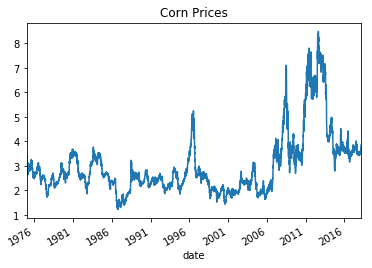

In [64]:
final_df.price.plot(title='Corn Prices');

/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/anaconda3/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))


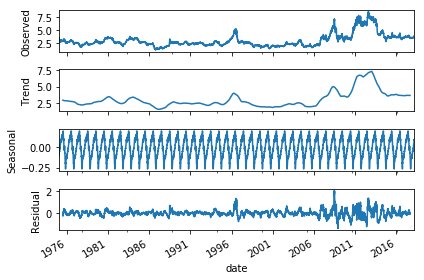

In [6]:
decomposition = seasonal_decompose(final_df.price, freq=252)
decomposition.plot();

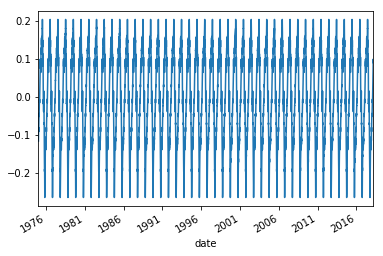

In [7]:
decomposition.seasonal.plot()

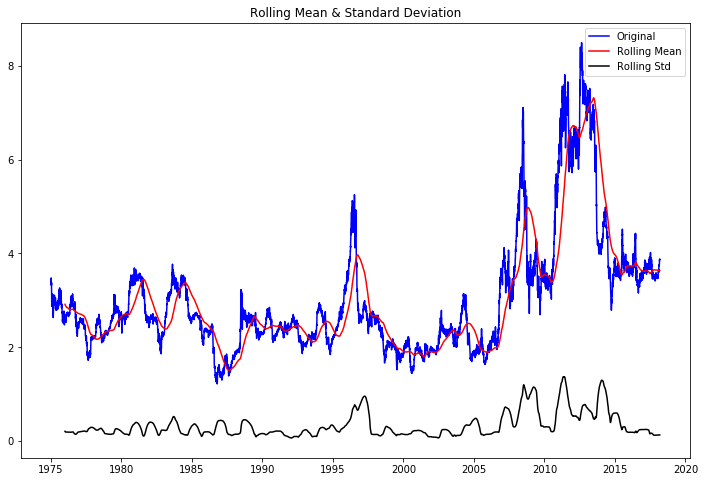

Results of Dickey-Fuller Test:
Test Statistic   -2.801737
p-value           0.058026
dtype: float64


In [6]:
# Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=252, center=False).mean()
    rolstd = timeseries.rolling(window=252, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)
    
test_stationarity(final_df.price)

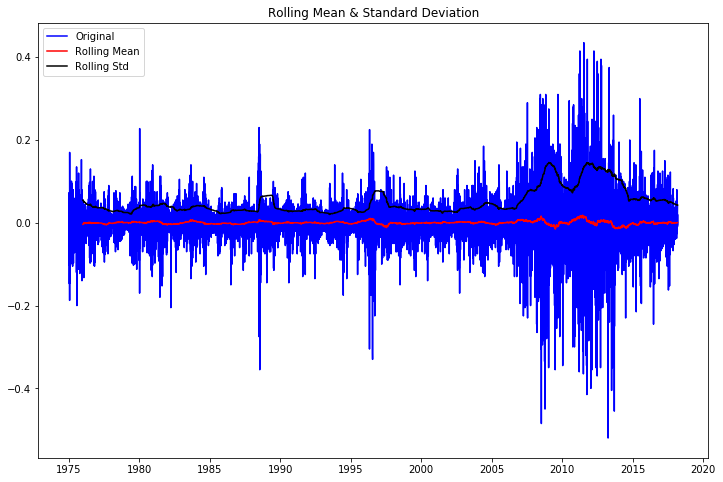

Results of Dickey-Fuller Test:
Test Statistic   -1.469466e+01
p-value           3.011577e-27
dtype: float64


In [7]:
# first difference
final_df['first_diff'] = final_df.price.diff()

# D-F test on first dif column
# need to dropna because first differencing will render the first row nan
test_stationarity(final_df.first_diff.dropna())

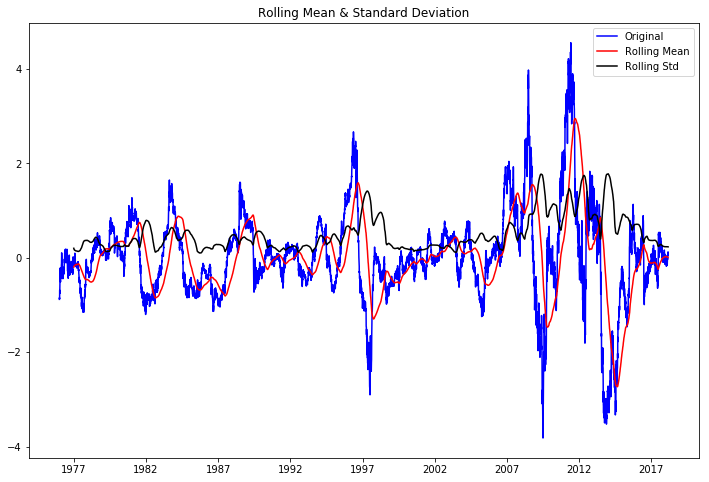

Results of Dickey-Fuller Test:
Test Statistic   -5.188701
p-value           0.000009
dtype: float64


In [8]:
# seasonal difference
final_df['seasonal_diff'] = final_df.price.diff(252)

# D-F test on dif column
test_stationarity(final_df.seasonal_diff.dropna())

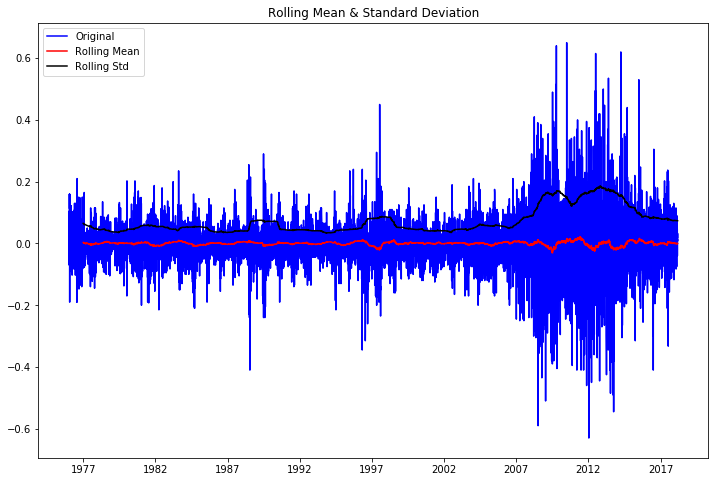

Results of Dickey-Fuller Test:
Test Statistic   -1.451608e+01
p-value           5.622084e-27
dtype: float64


In [9]:
# seasonal + first difference
final_df['seasonal_first_diff'] = final_df.price.diff().diff(252)

# D-F test
test_stationarity(final_df.seasonal_first_diff.dropna())

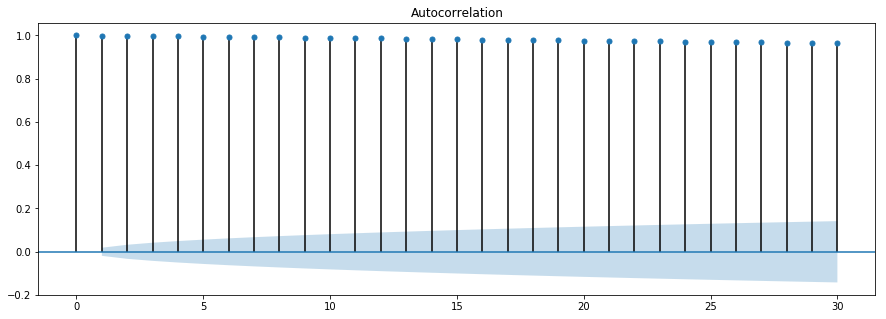

In [76]:
fig, ax = plt.subplots(figsize=(15,5))
plot_acf(final_df.price, lags=30, ax=ax);

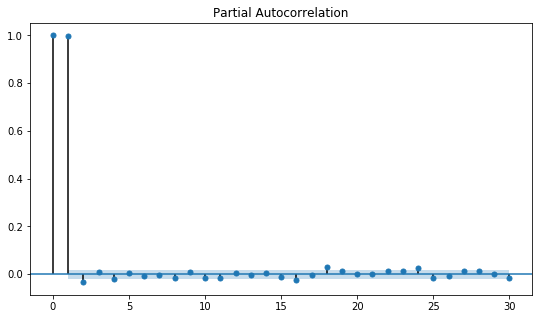

In [31]:
fig, ax = plt.subplots(figsize=(9,5))
plot_pacf(final_df.price, lags=30, ax=ax);

In [11]:
train = final_df.head(9000)
test = final_df.tail(final_df.shape[0] - 9000)

In [69]:
final_df.head()

,price,DEWP,Fog,Hail,MAX,MIN,PRCP,Rain/Drizzle,SLP,Snow/Ice pellets,TEMP,Thunder,Tornado/Funnel cloud,VISIB,WDSP,first_diff,seasonal_diff,seasonal_first_diff
date,,,,,,,,,,,,,,,,,,
1975-01-02,3.4375,21.699458,0.272242,0.000000,41.133452,24.173132,0.075762,0.179715,1021.942063,0.366548,32.081317,0.014235,0.0,14.337089,8.382384,NaN,NaN,NaN
1975-01-03,3.4050,23.128272,0.329787,0.000000,40.896188,23.129300,0.101460,0.338652,1020.194599,0.349291,32.074468,0.003546,0.0,14.615653,7.834220,-0.0325,NaN,NaN
1975-01-06,3.4775,25.417753,0.345196,0.003559,44.551601,24.910142,0.059527,0.282918,1017.427458,0.313167,34.404270,0.001779,0.0,14.075390,7.163345,0.0725,NaN,NaN
1975-01-07,3.3750,29.574578,0.465241,0.000000,46.225312,28.506863,0.096015,0.299465,1015.129889,0.260250,37.113191,0.021390,0.0,12.116546,6.709180,-0.1025,NaN,NaN
1975-01-08,3.3475,31.356526,0.500888,0.003552,47.084725,30.735169,0.196558,0.440497,1012.940000,0.227353,38.792007,0.083481,0.0,11.764843,7.885346,-0.0275,NaN,NaN


In [ ]:
p = 1 # number of lagged values
d = 1 # number of diffs in lag
q = 0 # lagged errors

# seasonal model
P = 1
D = 1
Q = 0

s = 252  # days in season

exog = final_df.drop(['price'], axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q), seasonal_order=(P,D,Q,s))
results = model.fit()
results.summary()

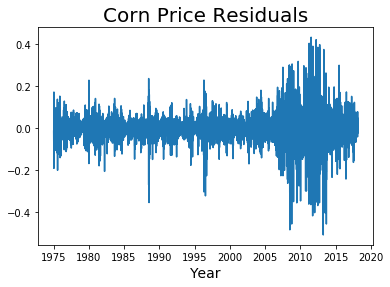

In [15]:
residuals = results.resid[5:]
plt.plot(residuals)
plt.title('Corn Price Residuals', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [20]:
# cotton model
main_df = pd.read_csv('~/desktop/main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
cotton = cotton[cotton.date > pd.datetime(1974,12,31)]
final_df = pd.merge(cotton, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud',
       'VISIB', 'WDSP']


p = 1 # lagged values
d = 1 # diffs
q = 3 # lagged errors

# seasonal model
#P = 1
#D = 1
#Q = 1

#s = 252  # days preceding

exog = final_df.drop(['price'], axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10899
Model:               SARIMAX(1, 1, 3)   Log Likelihood               32436.104
Date:                Sun, 08 Apr 2018   AIC                         -64830.209
Time:                        14:57:22   BIC                         -64676.984
Sample:                    01-02-1975   HQIC                        -64778.564
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 -1.78e-16   1.01e-12     -0.000      1.000   -1.98e-12    1.98e-12
recession               -0.0028      0.003     -0.837      0.403      -0.009       0.004
DEWP                 -7.172e-05      0.000     -0.493      0.622      -0.000       0.000
Fog                      0.0014      0.003      0.418      0.676      -0.005       0.008
Hail                    -0.0071      0.048     -0.148      0.882      -0.101       0.086
MAX                   7.259e-05      0.000      0.368      0.713      -0.000       0.000
MIN                      0.0002      0.000      0.952      0.341      -0.000       0.001
PRCP                    -0.0014      0.003     -0.492      0.623      -0.007       0.004
Rain/Drizzle            -0.0032      0.002     -1.495      0.135      -0.007       0.001
SLP                  -1.105e-05   5.93e-05     -0.186      0.852      -0.000       0.000
Snow/Ice pellets         0.0010      0.003      0.319      0.750      -0.005       0.007
TEMP                    -0.0001      0.000     -0.318      0.751      -0.001       0.001
Thunder                 -0.0030      0.004     -0.805      0.421      -0.010       0.004
Tornado/Funnel cloud    -0.1359      0.122     -1.111      0.266      -0.376       0.104
VISIB                   -0.0001      0.000     -0.433      0.665      -0.001       0.000
WDSP                 -4.399e-05      0.000     -0.257      0.797      -0.000       0.000
ar.L1                   -0.3268      0.284     -1.150      0.250      -0.883       0.230
ma.L1                    0.3716      0.284      1.308      0.191      -0.185       0.928
ma.L2                    0.0173      0.013      1.302      0.193      -0.009       0.043
ma.L3                   -0.0129      0.005     -2.553      0.011      -0.023      -0.003
sigma2                   0.0002   3.45e-07    441.128      0.000       0.000       0.000
===================================================================================
Ljung-Box (Q):                      164.70   Jarque-Bera (JB):           4507221.07
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.99   Skew:                            -3.04
Prob(H) (two-sided):                  0.00   Kurtosis:                       102.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.87e+25. Standard errors may be unstable.
"""

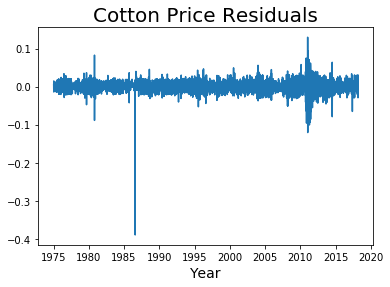

In [21]:
residuals = results.resid[5:]
plt.plot(residuals)
plt.title('Cotton Price Residuals', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [22]:
# wheat model
main_df = pd.read_csv('~/desktop/main_df.csv')
main_df['DATE'] = pd.to_datetime(main_df.DATE)
wheat = wheat[wheat.date > pd.datetime(1974,12,31)]
final_df = pd.merge(wheat, main_df, how='left', left_on='date', right_on='DATE')
final_df.drop('DATE', axis=1, inplace=True)
final_df.set_index('date', inplace=True)
final_df.columns = ['price', 'recession', 'DEWP', 'Fog', 'Hail', 'MAX', 'MIN', 'PRCP', 'Rain/Drizzle',
       'SLP', 'Snow/Ice pellets', 'TEMP', 'Thunder', 'Tornado/Funnel cloud',
       'VISIB', 'WDSP']


p = 1 # lagged values
d = 1 # diffs
q = 1 # lagged errors

# seasonal model
#P = 1
#D = 1
#Q = 1

#s = 252  # days preceding

exog = final_df.drop(['price'], axis=1)
exog = sm.add_constant(exog)

#SARIMAX model
model = sm.tsa.statespace.SARIMAX(endog=final_df.price.values, exog=exog, order=(p,d,q))
results = model.fit()
results.summary()

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                10834
Model:               SARIMAX(1, 1, 1)   Log Likelihood                9907.948
Date:                Sun, 08 Apr 2018   AIC                         -19777.896
Time:                        15:05:28   BIC                         -19639.377
Sample:                    04-04-1975   HQIC                        -19731.194
                         - 03-07-2018                                         
Covariance Type:                  opg                                         
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                 1.501e-10   4.42e-12     33.977      0.000    1.41e-10    1.59e-10
recession                0.0404      0.019      2.126      0.034       0.003       0.078
DEWP                    -0.0013      0.001     -1.136      0.256      -0.004       0.001
Fog                      0.0237      0.029      0.819      0.413      -0.033       0.081
Hail                     0.0243      0.448      0.054      0.957      -0.853       0.901
MAX                     -0.0006      0.002     -0.316      0.752      -0.004       0.003
MIN                     -0.0010      0.002     -0.539      0.590      -0.005       0.003
PRCP                    -0.0750      0.022     -3.391      0.001      -0.118      -0.032
Rain/Drizzle            -0.0090      0.017     -0.520      0.603      -0.043       0.025
SLP                     -0.0002      0.000     -0.498      0.618      -0.001       0.001
Snow/Ice pellets        -0.0599      0.028     -2.120      0.034      -0.115      -0.005
TEMP                     0.0023      0.003      0.729      0.466      -0.004       0.008
Thunder                  0.0301      0.028      1.058      0.290      -0.026       0.086
Tornado/Funnel cloud     0.4143      0.927      0.447      0.655      -1.403       2.231
VISIB                   -0.0002      0.003     -0.064      0.949      -0.006       0.006
WDSP                     0.0026      0.001      1.980      0.048     2.6e-05       0.005
ar.L1                    0.3092      0.051      6.121      0.000       0.210       0.408
ma.L1                   -0.3712      0.049     -7.587      0.000      -0.467      -0.275
sigma2                   0.0094   3.82e-05    245.817      0.000       0.009       0.009
===================================================================================
Ljung-Box (Q):                      224.07   Jarque-Bera (JB):            893249.70
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               6.48   Skew:                            -1.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        47.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.2e+26. Standard errors may be unstable.
"""

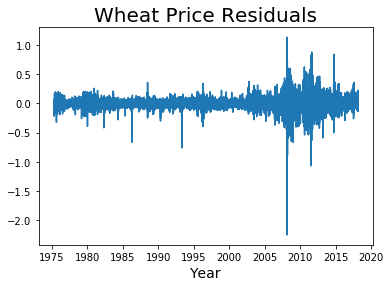

In [23]:
residuals = results.resid[5:]
plt.plot(residuals)
plt.title('Wheat Price Residuals', fontsize=20)
plt.xlabel('Year', fontsize=14);

In [181]:
stat_co = [x for x in df.STN.value_counts()]

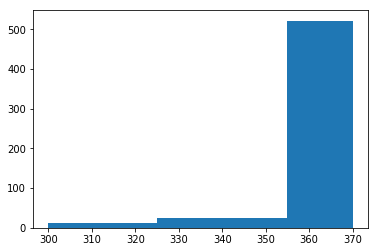

In [217]:
# how many days of data does each station have
plt.hist(stat_co, bins=[300,325,355,370]);

In [252]:
us_stations['coords'] = us_stations['LAT'].astype(str) + ' ' + us_stations['LON'].astype(str)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [270]:
vincenty((float(us_stations.coords[3344].split()[0]), float(us_stations.coords[3344].split()[1])),
        (float(us_stations.coords[3345].split()[0]), float(us_stations.coords[3345].split()[1]))).miles

36.20990630560611

In [264]:
us_stations = us_stations[us_stations.USAF.isin(common_stations)]